In [401]:
import Pkg; 
Pkg.add("JuMP")
Pkg.add("GLPK")
Pkg.add("DataFrames")
Pkg.add("CSV")
Pkg.add("Plots")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


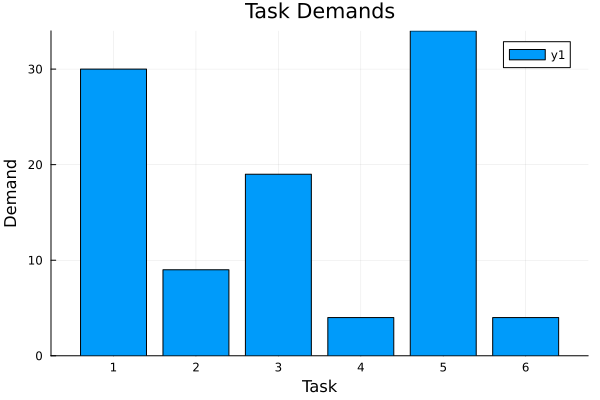

In [407]:
using JuMP
using GLPK
using DataFrames
using CSV
using Random
using Plots

# task preffered
preferences_df = DataFrame(CSV.File("preferences.csv", header=true))
preferences = Matrix(preferences_df[:, 2:end])

# interval preffered
disponibility_df = DataFrame(CSV.File("disponibility.csv", header=true))
disponibility_preferences = Matrix(disponibility_df[:, 2:end])  # Assuming preferences start from the 2nd column

# Number of volunteers, tasks and intervals (53 ,6,7)
m, n = size(preferences)
intervals = size(disponibility_preferences, 2)

# Generate random positive integer demands that sum up 100
function generate_random_demands(m, n)
    breaks = sort(rand(1:m-1, n-1))
    demands = diff([0; breaks; m])
    demands = round.(Int, 100 * demands / sum(demands))
    return demands
end
demands = generate_random_demands(m, n)

#Intervals demands
interval_names = [
"Vineri 17 mai : 19:00 - 23 :00", 
"Sambata 18 mai : 9:00 - 13:00", 
"Sambata 18 mai : 13:00 - 17:00",
"Sambata 18 mai : 17:00 - 21:00",
"Duminica 19 mai : 9:00 - 13:00",
"Duminica 19 mai : 13 : 00 - 17 :00",
"Duminica 19 mai : 17 : 00 - 21 : 00"]

#plot task demands
bar([1:6], demands, title="Task Demands", xlabel="Task",ylabel="Demand")


In [408]:
model = Model(GLPK.Optimizer)
intervals = 7
# Define the decision variables
@variable(model, x[1:m, 1:n, 1:intervals], Bin)

# Define the objective: maximize total preference score
@objective(model, Max, sum(preferences[i, j] * x[i, j, d] for i in 1:m, j in 1:n, d in 1:intervals))

# Define the constraints: each employee is assigned to exactly one task per interval
@constraint(model, [i in 1:m, d in 1:intervals], sum(x[i, j, d] for j in 1:n) <= 1)

# Each task is assigned exactly the number of employees as its demand over the tasks
@constraint(model, [j in 1:n], sum(x[i, j, d] for i in 1:m, d in 1:intervals) == demands[j])

# Volunteer can only be assigned to tasks on intervals they are available
@constraint(model, [i in 1:m, d in 1:intervals], sum(x[i, j, d] for j in 1:n) <= disponibility_preferences[i, d])

# each volunteer can't have more than 2 tasks
@constraint(model, [i in 1:m], sum(sum(x[i, :, d]) for d in 1:intervals) <= 2)

# Solve the model
optimize!(model)

# Print the results
println("Optimal assignment of employees to tasks:")
preferences_sum = zeros(Int, n)
notLeftOut = zeros(Int, m)
for i in 1:m
    for j in 1:n
        for d in 1:intervals
            if value(x[i, j, d]) > 0.5
                println("Volunteer $i assigned to Task $j on $(interval_names[d]) with satisfaction score $(preferences[i, j])")
                preferences_sum[satisfaction[i,j]] +=1
                notLeftOut[i] = 1
            end
        end
    end
end
println("Maximum total satisfaction: ", objective_value(model))

Optimal assignment of employees to tasks:
Volunteer 1 assigned to Task 1 on Vineri 17 mai : 19:00 - 23 :00 with satisfaction score 6
Volunteer 1 assigned to Task 1 on Sambata 18 mai : 9:00 - 13:00 with satisfaction score 6
Volunteer 2 assigned to Task 1 on Sambata 18 mai : 9:00 - 13:00 with satisfaction score 5
Volunteer 2 assigned to Task 1 on Sambata 18 mai : 13:00 - 17:00 with satisfaction score 5
Volunteer 3 assigned to Task 2 on Vineri 17 mai : 19:00 - 23 :00 with satisfaction score 6
Volunteer 3 assigned to Task 2 on Sambata 18 mai : 9:00 - 13:00 with satisfaction score 6
Volunteer 4 assigned to Task 5 on Sambata 18 mai : 9:00 - 13:00 with satisfaction score 5
Volunteer 5 assigned to Task 5 on Vineri 17 mai : 19:00 - 23 :00 with satisfaction score 5
Volunteer 6 assigned to Task 1 on Vineri 17 mai : 19:00 - 23 :00 with satisfaction score 6
Volunteer 6 assigned to Task 1 on Sambata 18 mai : 9:00 - 13:00 with satisfaction score 6
Volunteer 7 assigned to Task 2 on Sambata 18 mai : 17

Number of volunteers left out: 1


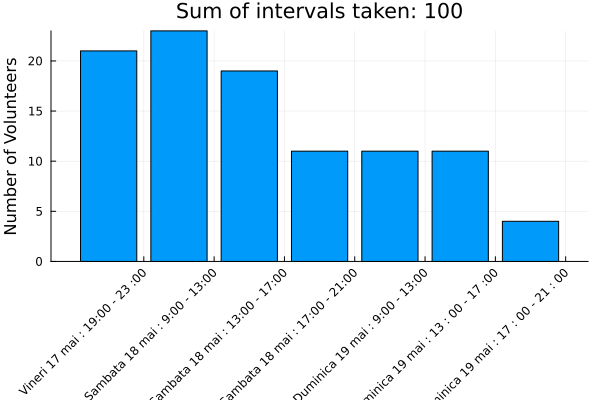

In [409]:
#print number of volunteers left out
println("Number of volunteers left out: ", m-sum(notLeftOut))
volunteers_per_interval = zeros(Int, days)
for d in 1:days
    volunteers_per_interval[d] = sum(sum(value.(x[i, :, d])) for i in 1:m)
end

# Plot the number of volunteers per interval
title_text = "Sum of intervals taken: $(sum(volunteers_per_interval))"
bar(interval_names, volunteers_per_interval, xlabel="Intervals", ylabel="Number of Volunteers", legend=false, xticks=(1:days, interval_names), xrotation=45, title=title_text)


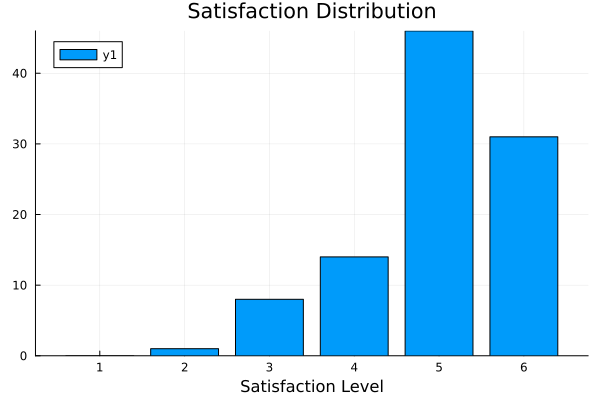

In [410]:
bar(1:n, preferences_sum, title="Satisfaction Distribution", xlabel="Satisfaction Level")